<a href="https://colab.research.google.com/github/makgogo/Makgogo-Mphela/blob/main/ML_multiple_linear_regression_predicting_profit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Profit estimation of the company



A venture capital firm is trying to understand which companies should they invest

Lets brake down the problem statement into pieces

- Decide companies to invest
- Predict the profit company make
- Based on companies expenses/expenditure and location (
     R & D Spend ,
     Administration ,
     Marketing Spend,
     State )
- Calculate Profit

## 1. Reading and Understanding the Data

importing the libraries

In [ ]:
#basic libraries and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#statmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
#sklearn-dataprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import f_regression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error
#sklearn-models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
sns.set_theme(style='darkgrid', palette='Accent')
pd.options.display.float_format = '{:,.2f}'.format

load dataset

In [ ]:
companies_data = pd.read_csv("/content/1000_Companies.csv")

In [ ]:
companies_data.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,"165,349.20","136,897.80","471,784.10",New York,"192,261.83"
1,"162,597.70","151,377.59","443,898.53",California,"191,792.06"
2,"153,441.51","101,145.55","407,934.54",Florida,"191,050.39"
3,"144,372.41","118,671.85","383,199.62",New York,"182,901.99"
4,"142,107.34","91,391.77","366,168.42",Florida,"166,187.94"


About dataset:` dataset contains five(5) columns namely: R&D spend,Administration,Marketing Spend,State and Profit`

-R&D Spend:
`R&D Spend, short for Research and Development Spending, represents the amount of money a company invests in research and development activities. This includes expenses related to innovation, product development, and technological advancements.`

-Administration:
`Administration refers to the costs associated with running the day-to-day operations of a business. This column typically includes expenses like employee salaries, office rent, utilities, and other overhead costs that are necessary for the company's administrative functions`.

-Marketing Spend:
`Marketing Spend represents the funds allocated for marketing activities, including advertising, promotions, and campaigns. It encompasses the expenses aimed at promoting the company's products or services to attract and retain customers.`

-State:
`State indicates the geographical location or state where the company is based or operates. It's useful for identifying the specific region or jurisdiction in which the company is situated, which can have implications for regulatory compliance and market dynamics.`

-Profit:
`Profit signifies the financial gain a business achieves when its total revenue exceeds its total expenses. It is a critical indicator of a company's financial performance and reflects its ability to generate earnings after covering all costs.`

In [ ]:
companies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        1000 non-null   float64
 1   Administration   1000 non-null   float64
 2   Marketing Spend  1000 non-null   float64
 3   State            1000 non-null   object 
 4   Profit           1000 non-null   float64
dtypes: float64(4), object(1)
memory usage: 39.2+ KB


In [ ]:
companies_data.shape

(1000, 5)

In [ ]:
companies_data.columns

Index(['R&D Spend', 'Administration', 'Marketing Spend', 'State', 'Profit'], dtype='object')

In [ ]:
companies_data['State'].unique()

array(['New York', 'California', 'Florida'], dtype=object)

` This column contain three states which is Califonia,Newyork and Floida.`

In [ ]:
companies_data.dtypes

R&D Spend          float64
Administration     float64
Marketing Spend    float64
State               object
Profit             float64
dtype: object

In [ ]:
companies_data['State'] = companies_data['State'].astype('category')

In [ ]:
companies_data['State'].dtypes

CategoricalDtype(categories=['California', 'Florida', 'New York'], ordered=False)

## 2. Data Cleaning

In [ ]:
companies_data.isnull().sum()

R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64

`From the above we can say that there is no null values present!`

In [ ]:
companies_data.duplicated().any().sum()

1

In [ ]:

# Drop duplicate rows based on all columns
companies_data_no_duplicates = companies_data.drop_duplicates()

print("Original DataFrame:")
print(companies_data)

print("\nDataFrame with Duplicates Removed:")
print(companies_data_no_duplicates)


Original DataFrame:
     R&D Spend  Administration  Marketing Spend       State     Profit
0   165,349.20      136,897.80       471,784.10    New York 192,261.83
1   162,597.70      151,377.59       443,898.53  California 191,792.06
2   153,441.51      101,145.55       407,934.54     Florida 191,050.39
3   144,372.41      118,671.85       383,199.62    New York 182,901.99
4   142,107.34       91,391.77       366,168.42     Florida 166,187.94
..         ...             ...              ...         ...        ...
995  54,135.00      118,452.00       173,232.67  California  95,279.96
996 134,970.00      130,390.08       329,204.02  California 164,336.61
997 100,275.47      241,926.31       227,142.82  California 413,956.48
998 128,456.23      321,652.14       281,692.32  California 333,962.19
999 161,181.72      270,939.86       295,442.17    New York 476,485.43

[1000 rows x 5 columns]

DataFrame with Duplicates Removed:
     R&D Spend  Administration  Marketing Spend       State     Pro

In [ ]:
companies_data.shape , companies_data_no_duplicates.shape

((1000, 5), (999, 5))

## 3. EDA

Checking for outliers

In [ ]:
companies_data_no_duplicates.columns.values

array(['R&D Spend', 'Administration', 'Marketing Spend', 'State',
       'Profit'], dtype=object)

<Axes: >

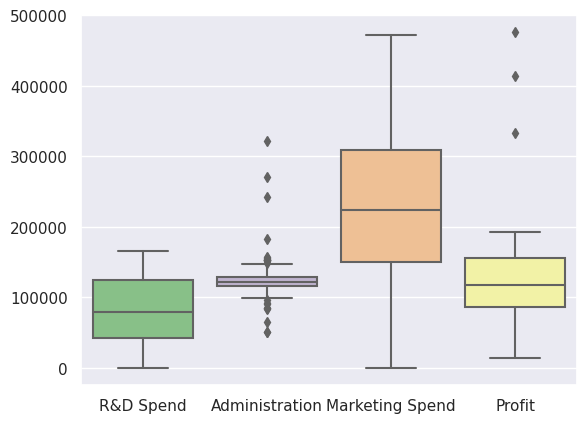

In [ ]:
sns.boxplot(data=companies_data_no_duplicates)

`we have extreme values on Administration and Profit column`

Removing outliears

In [ ]:
# Calculate Q1 and Q3 for the "Administration" and "Profit" columns
Q3, Q1 = np.percentile(companies_data_no_duplicates[["Administration","Marketing Spend", "Profit"]], [75, 25])

# Calculate the IQR
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers based on the specified bounds for each column
companies_data_no_duplicates = companies_data_no_duplicates[
    (companies_data_no_duplicates["Administration"] >= lower_bound) &
    (companies_data_no_duplicates["Administration"] <= upper_bound) &
    (companies_data_no_duplicates["Profit"] >= lower_bound) &
    (companies_data_no_duplicates["Profit"] <= upper_bound)

]


In [ ]:
companies_data.shape , companies_data_no_duplicates.shape

((1000, 5), (995, 5))

<Axes: >

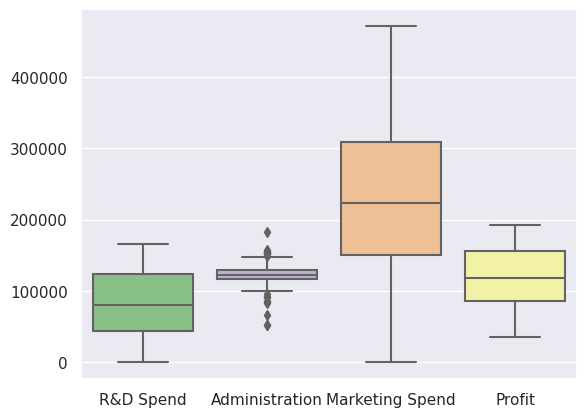

In [ ]:
sns.boxplot(data=companies_data_no_duplicates)

In [ ]:
companies_data_no_duplicates.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,995.00,995.00,995.00,995.00
mean,"81,602.49","122,501.96","226,255.00","118,779.73"
std,"46,486.62","9,147.68","91,585.27","39,691.39"
min,0.00,"51,283.14",0.00,"35,673.41"
25%,"43,081.00","116,635.11","150,727.91","85,909.67"
50%,"79,611.00","122,402.27","223,872.47","117,354.00"
75%,"124,232.00","129,076.94","309,181.57","155,163.22"
max,"165,349.20","182,645.56","471,784.10","192,261.83"


## Data Visualization

<Axes: >

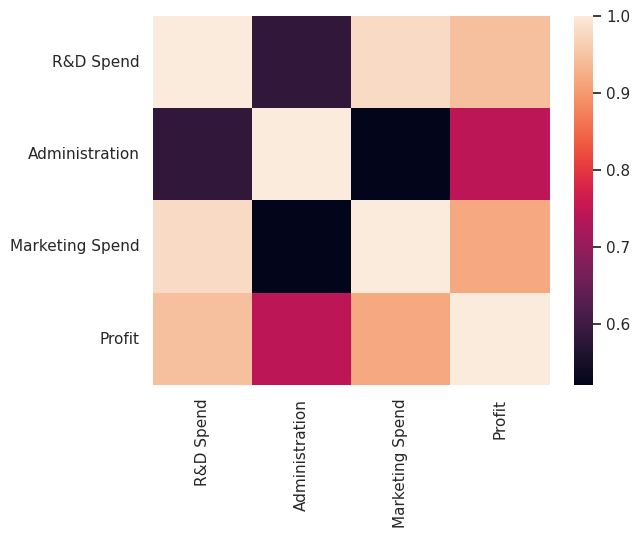

In [ ]:
# Building correlation matrix
sns.heatmap(companies_data.corr())

Lets Analyse the relationship between Dependent variable with other independent variable...

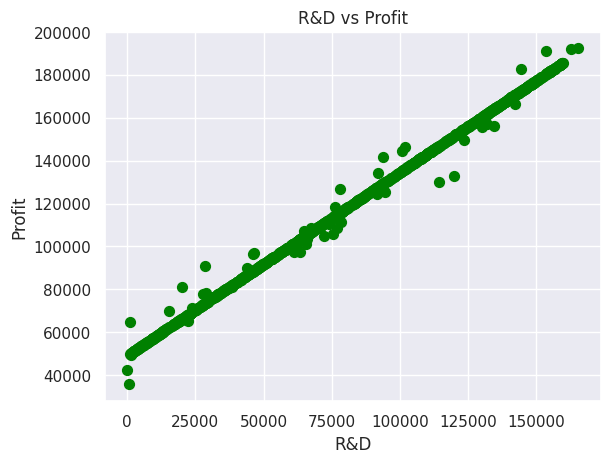

In [ ]:
#Plot R&D vs Profit............
x1 = companies_data_no_duplicates.iloc[:, 0].values
y1 = companies_data_no_duplicates.iloc[:, -1].values
plt.scatter(x1,y1,color='Green',s=50)
plt.xlabel('R&D')
plt.ylabel('Profit')
plt.title('R&D vs Profit')
plt.show()

`From the above plot we can able to visualize that R&D and Profit has positive correlation.`

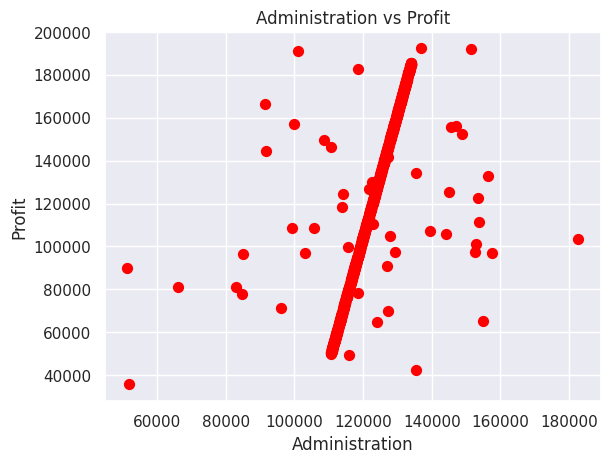

In [ ]:
#Plot Administration vs Profit............
x1 = companies_data_no_duplicates.iloc[:, 1].values
y1 = companies_data_no_duplicates.iloc[:, -1].values
plt.scatter(x1,y1,color='Red',s=50)
plt.xlabel('Administration')
plt.ylabel('Profit')
plt.title('Administration vs Profit')
plt.show()

`From above plot - Zero correlation between Administration and Profit.`

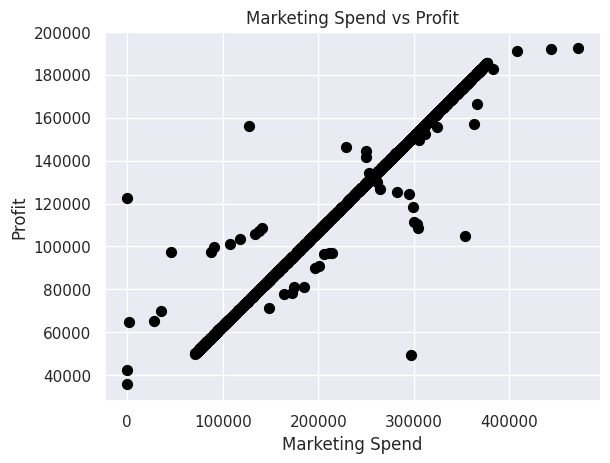

In [ ]:
#Plot Marketing Spend vs Profit
x1 = companies_data_no_duplicates.iloc[:, 2].values
y1 = companies_data_no_duplicates.iloc[:, -1].values
plt.scatter(x1,y1,color='Black',s=50)
plt.xlabel('Marketing Spend')
plt.ylabel('Profit')
plt.title('Marketing Spend vs Profit')
plt.show()

`From above plot -High correlation between Marketing Spend and Profit.`

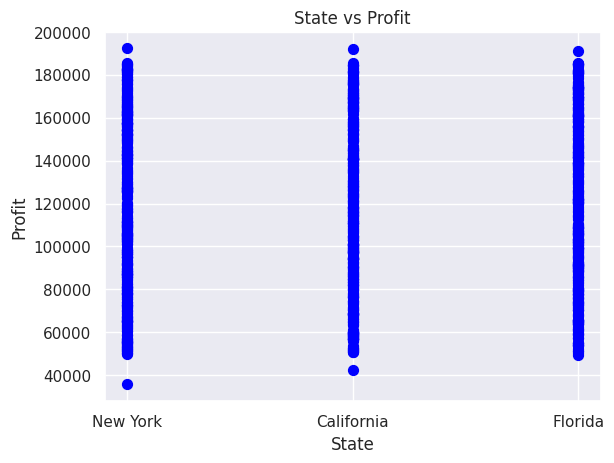

In [ ]:
#Plot State vs Profit
x1 = companies_data_no_duplicates.iloc[:, 3].values
y1 = companies_data_no_duplicates.iloc[:, -1].values
plt.scatter(x1,y1,color='Blue',s=50)
plt.xlabel('State')
plt.ylabel('Profit')
plt.title('State vs Profit')
plt.show()

Visualising Numerical Variables

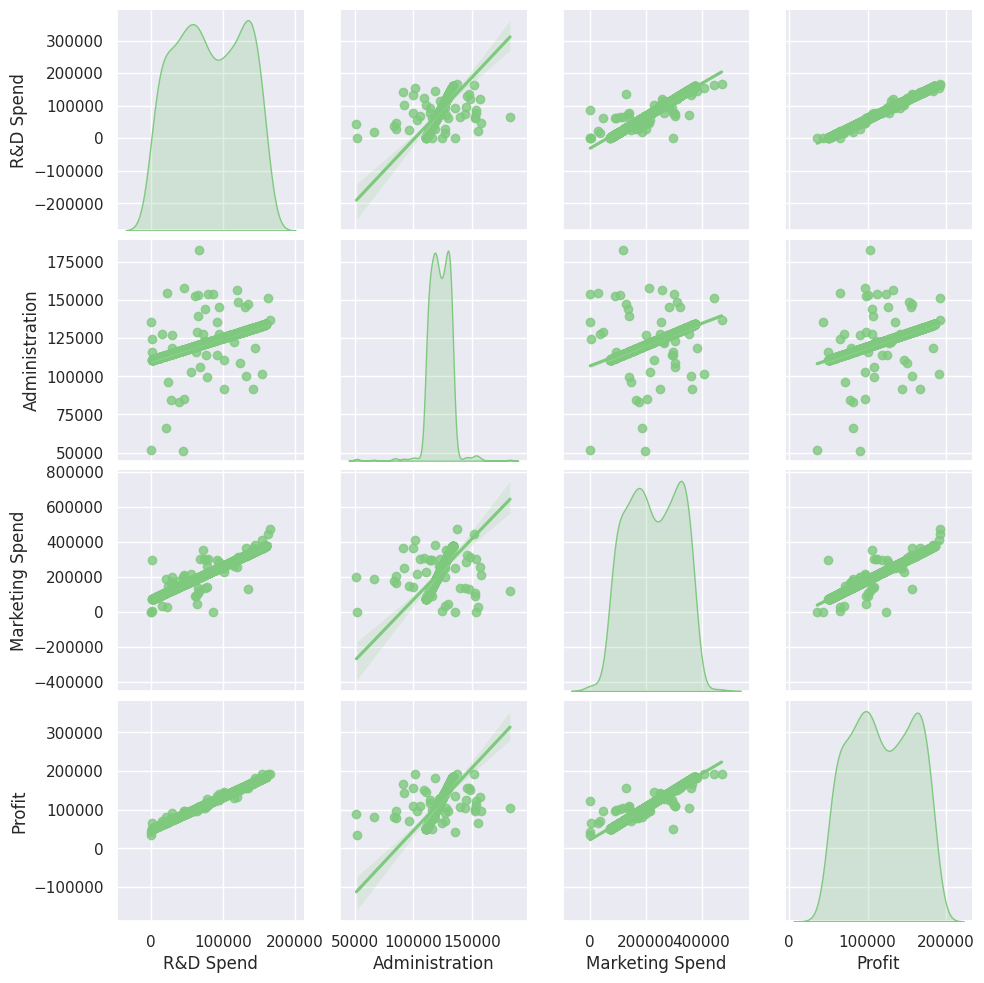

In [ ]:
sns.pairplot(companies_data_no_duplicates[['R&D Spend', 'Administration', 'Marketing Spend', 'Profit']], kind="reg", diag_kind="kde")
plt.show()

insights

`- R&D Spend and Marketing Spend are in linear relation with target variable(profit)`

Profit Distribution

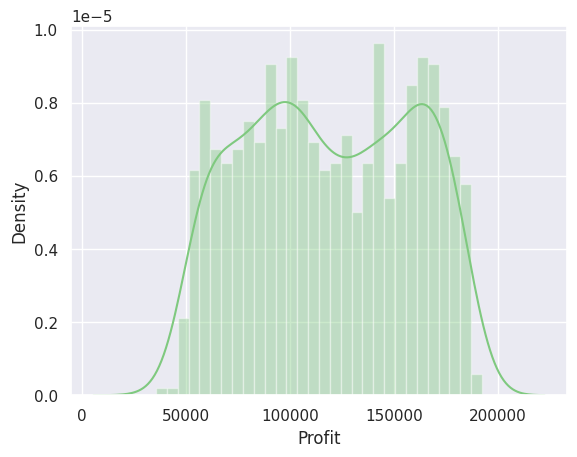

In [ ]:
sns.distplot(companies_data_no_duplicates["Profit"], bins=30)
plt.show()

R&D Spend vs. Profit Correlation

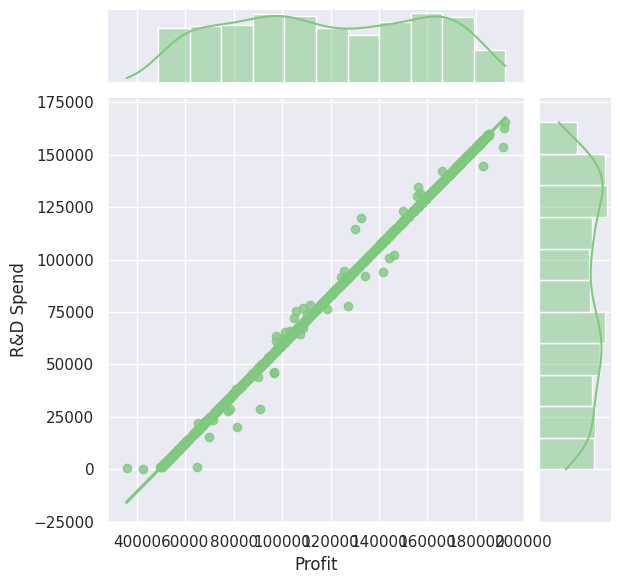

In [ ]:
sns.jointplot(x=companies_data_no_duplicates["Profit"], y=companies_data_no_duplicates["R&D Spend"], kind="reg")
plt.show()

Visualising Categorical Variables

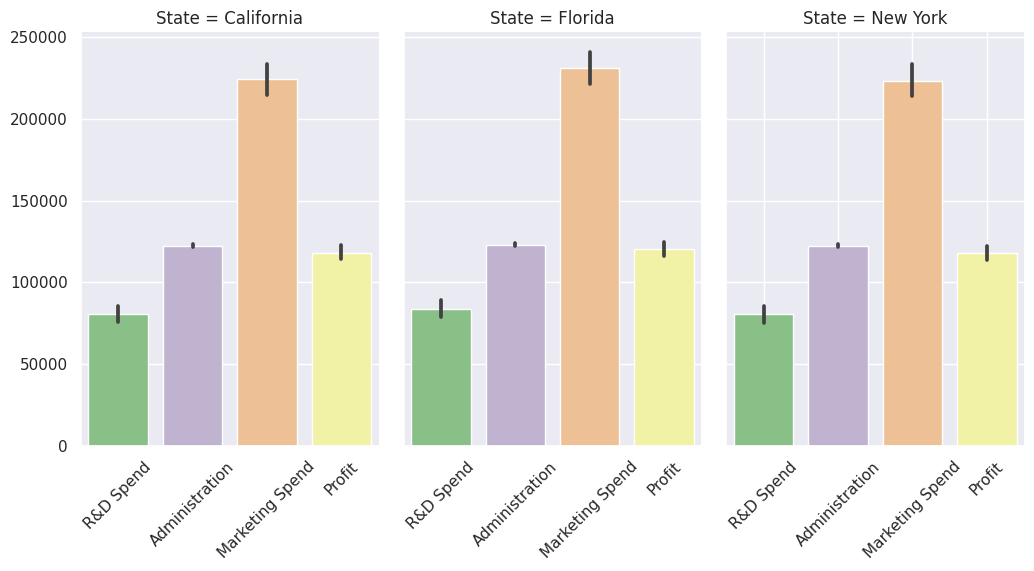

In [ ]:
g=sns.FacetGrid(data=companies_data_no_duplicates, col="State", height=5, aspect=0.7)
g.map_dataframe(sns.barplot, palette="Accent")
g.set_xticklabels(rotation=45)
plt.grid(True)
plt.show()

insights:

-Marketing Spend are higher at Florida than other states.

-R&D Spend are same for all of the states.







## 4. Data Preparation/ Data Preprocessing

In [ ]:
companies = companies_data_no_duplicates.copy()

In [ ]:
companies.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,"165,349.20","136,897.80","471,784.10",New York,"192,261.83"
1,"162,597.70","151,377.59","443,898.53",California,"191,792.06"
2,"153,441.51","101,145.55","407,934.54",Florida,"191,050.39"
3,"144,372.41","118,671.85","383,199.62",New York,"182,901.99"
4,"142,107.34","91,391.77","366,168.42",Florida,"166,187.94"


Defining input(x) and target variables(y)

In [ ]:
# Extracting the dependent and independent variables, excluding the index column
x = companies.iloc[:, :-1].values  # Exclude the first and the last column
y = companies.iloc[:, 4].values   # Assuming you want the last column (index 4 in zero-based indexing)

In [ ]:
x

array([[165349.2, 136897.8, 471784.1, 'New York'],
       [162597.7, 151377.59, 443898.53, 'California'],
       [153441.51, 101145.55, 407934.54, 'Florida'],
       ...,
       [97209.0, 124813.3635, 256344.0701, 'New York'],
       [54135.0, 118451.999, 173232.6695, 'California'],
       [134970.0, 130390.08, 329204.0228, 'California']], dtype=object)

In [ ]:
y

array([192261.83   , 191792.06   , 191050.39   , 182901.99   ,
       166187.94   , 156991.12   , 156122.51   , 155752.6    ,
       152211.77   , 149759.96   , 146121.95   , 144259.4    ,
       141585.52   , 134307.35   , 132602.65   , 129917.04   ,
       126992.93   , 125370.37   , 124266.9    , 122776.86   ,
       118474.03   , 111313.02   , 110352.25   , 108733.99   ,
       108552.04   , 107404.34   , 105733.54   , 105008.31   ,
       103282.38   , 101004.64   ,  99937.59   ,  97483.56   ,
        97427.84   ,  96778.92   ,  96712.8    ,  96479.51   ,
        90708.19   ,  89949.14   ,  81229.06   ,  81005.76   ,
        78239.91   ,  77798.83   ,  71498.49   ,  69758.98   ,
        65200.33   ,  64926.08   ,  49490.75   ,  42559.73   ,
        35673.41   , 123485.2464 ,  82155.48418, 125867.0108 ,
       104976.1696 ,  89803.10053,  75297.23305, 114284.5283 ,
       171985.0761 ,  72337.96774, 169566.5772 , 158670.9451 ,
       114522.8756 ,  85842.60573, 101106.2297 ,  59328

Checking for multicollinearity

In [ ]:
numerical = companies.drop(columns=["State", "Profit"])
vif = pd.DataFrame()
vif["Features"] = numerical.columns
vif["VIF"] = [variance_inflation_factor(numerical.values, i) for i in range(numerical.shape[1])]
vif["VIF"] = round(vif["VIF"], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,Marketing Spend,146.69
0,R&D Spend,80.00
1,Administration,18.58


Insights:

- VIF scores are higher for R&D and Marketing Spend.

- Since Administration is not so correlated with Profit as other variables, we will consider dropping this variable, which will drive VIF factor down.

Encoding Categorical Data and Creating dummy variables

one-hot-encoding

In [ ]:
# Create a DataFrame from the data
x = pd.DataFrame(x, columns=['R&D Spend', 'Administration', 'Marketing Spend', 'State'])

# Perform one-hot encoding on the 'State' column
x_encoded = pd.get_dummies(x, columns=['State'])


In [ ]:
# Display the encoded DataFrame
x_encoded.head()

,R&D Spend,Administration,Marketing Spend,State_California,State_Florida,State_New York
0,"165,349.20","136,897.80","471,784.10",0,0,1
1,"162,597.70","151,377.59","443,898.53",1,0,0
2,"153,441.51","101,145.55","407,934.54",0,1,0
3,"144,372.41","118,671.85","383,199.62",0,0,1
4,"142,107.34","91,391.77","366,168.42",0,1,0


Avoiding Dummy Variable Trap

In [ ]:
# drop one of the columns to avoid the Dummy Variable Trap
x_encoded = pd.get_dummies(x, columns=['State'], drop_first=True)



In [ ]:
# Display the encoded DataFrame
x_encoded.head()

,R&D Spend,Administration,Marketing Spend,State_Florida,State_New York
0,"165,349.20","136,897.80","471,784.10",0,1
1,"162,597.70","151,377.59","443,898.53",0,0
2,"153,441.51","101,145.55","407,934.54",1,0
3,"144,372.41","118,671.85","383,199.62",0,1
4,"142,107.34","91,391.77","366,168.42",1,0


Feature selection

In [ ]:
data = f_regression(x_encoded[["R&D Spend", "Administration", "Marketing Spend"]], y)
f_df = pd.DataFrame(data, index=[["F_statistic", "p_value"]], columns=x_encoded[["R&D Spend", "Administration", "Marketing Spend"]].columns).T
f_df

,F_statistic,p_value
R&D Spend,"505,325.09",0.00
Administration,"1,248.58",0.00
Marketing Spend,"24,870.25",0.00


Insights:

- R&D and Marketing has higher F_statistics which
  implies statistical significance.

- On the other hand Administration seems to have no
  effect in predicting the Profit, as we previously seen from correlation as well.

- We are going to drop Administration column as it  has no statistical significance in our model.

In [ ]:
x = x_encoded.drop(columns="Administration", inplace=True)

In [ ]:
x_encoded

,R&D Spend,Marketing Spend,State_Florida,State_New York
0,"165,349.20","471,784.10",0,1
1,"162,597.70","443,898.53",0,0
2,"153,441.51","407,934.54",1,0
3,"144,372.41","383,199.62",0,1
4,"142,107.34","366,168.42",1,0
...,...,...,...,...
990,"105,127.00","271,621.87",1,0
991,"46,798.00","159,075.91",0,0
992,"97,209.00","256,344.07",0,1
993,"54,135.00","173,232.67",0,0


Splitting the data into Train and Test set

In [ ]:
# Split the data into training and testing sets
x_encoded_train, x_encoded_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.2, random_state=42)


In [ ]:
#Checking if the split has approximately equal distributions of values
print(f"Train Florida: {x_encoded_train['State_Florida'].mean()}")
print(f"Test Florida: {x_encoded_test['State_Florida'].mean()}")
print(f"Train Marketing: {x_encoded_train['Marketing Spend'].mean()}")
print(f"Test Marketing: {x_encoded_test['Marketing Spend'].mean()}")

Train Florida: 0.32914572864321606
Test Florida: 0.3015075376884422
Train Marketing: 226305.10887085437
Test Marketing: 226054.55122678386


Scaling the Features

In [ ]:

# Scaling inputs
sc_x = StandardScaler()
x_encoded_train = sc_x.fit_transform(x_encoded_train)
x_encoded_test = sc_x.transform(x_encoded_test)

# Scaling target variable
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train.reshape(-1, 1))
y_test = sc_y.transform(y_test.reshape(-1, 1))


In [ ]:
y_train = y_train.reshape(796)
y_test = y_test.reshape(199)

## 5. Model Selection and Evaluation

In [ ]:
Rsqr_test = []  # Create an empty list to store R-squared values
order = range(1, 4)  # Create a range of polynomial degrees from 1 to 3
for n in order:
    pr = PolynomialFeatures(degree=n)  # Create a PolynomialFeatures transformer for degree n
    x_encoded_train_poly = pr.fit_transform(x_encoded_train)  # Transform the training data into polynomial features
    x_encoded_test_poly = pr.fit_transform(x_encoded_test)  # Transform the test data into polynomial features
    lr = LinearRegression()  # Create a Linear Regression model
    lr.fit(x_encoded_train_poly, y_train)  # Fit the model on the training data with polynomial features
    Rsqr_test.append(lr.score(x_encoded_test_poly, y_test))  # Calculate R-squared for the model on the test data
Rsqr_test

[0.9995009371042611, 0.9993575111861085, 0.998764757023665]

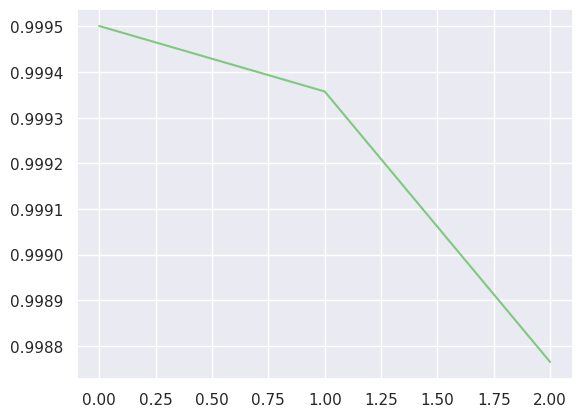

In [ ]:
plt.plot(Rsqr_test)
plt.show()

Support Vector regression

In [ ]:
svr = SVR()
svr.fit(x_encoded_train, y_train)
svr.score(x_encoded_test, y_test)

0.995424772969898

Decision Tree regression

In [ ]:
dt = DecisionTreeRegressor()
dt.fit(x_encoded_train, y_train)
dt.score(x_encoded_test, y_test)

0.9998024121535728

Random Forest regression

In [ ]:
rf = RandomForestRegressor()
rf.fit(x_encoded_train, y_train)
rf.score(x_encoded_test, y_test)

0.9996839076037085

  The best performing model is Multiple Linear Regression.

 Fitting multiple linear regression model to training set

In [ ]:
# Create and fit the linear regression model
regression_model = LinearRegression()
regression_model.fit(x_encoded_train, y_train)
r2_score = regression_model.score(x_encoded_test, y_test)

In [ ]:
# Adjusted R-square of the model
n = x_encoded_test.shape[0]
p = x_encoded_test.shape[1]

adjusted_r2 = 1-(1-r2_score)*(n-1)/(n-p-1)
adjusted_r2

0.999490647147648

##  6. Residuals analysis

Predicting the test set results

In [ ]:
# Make predictions on the test data
y_pred = regression_model.predict(x_encoded_test)
y_pred

array([-1.22257631, -1.60483325,  0.71723087,  1.22888246,  0.98256969,
       -0.09742318, -0.77835906, -0.83356988,  1.13040897,  1.59510327,
        0.34652488, -0.5397842 , -0.22156299, -0.98112954,  1.58369818,
        1.27300552, -0.76028479,  1.37919541,  0.02960534,  1.5848755 ,
        1.57180307,  1.61736157,  0.03234287,  0.65058771, -1.58235985,
       -0.96193778,  0.83357459, -0.03494089, -1.3839885 ,  0.49127777,
       -0.03330612,  0.60870744, -0.12827919, -1.51253789,  1.14572994,
        0.29861132,  1.66343059, -0.38454542,  0.57348958, -1.22027472,
        1.00619828,  1.24299312, -1.25874532, -0.40431325, -1.3477654 ,
       -0.22202744, -0.49422049,  1.10090278,  0.41044671, -1.03352827,
        0.12898225,  1.09462652,  1.12172461,  0.59570957,  1.16855692,
        0.06750623, -1.66791147, -0.24706932, -0.61692535, -0.53368106,
        0.99689545,  1.6246908 , -1.67317572,  1.14744502, -1.12359129,
        1.38006626,  1.20531777, -1.24846347, -1.3098262 ,  0.68

In [ ]:
y_test

array([-1.22424059, -1.60726911,  0.71948203,  1.22859894,  0.981789  ,
       -0.09681638, -0.78269413, -0.83526329,  1.12992669,  1.59912639,
        0.34802778, -0.54088461, -0.22202107, -0.98312079,  1.58688396,
        1.27556418, -0.76183027,  1.3792153 ,  0.02690112,  1.58531055,
        1.57496484,  1.6206153 ,  0.03239728,  0.65189003, -1.58556466,
       -0.96307597,  0.83524627, -0.03502229, -1.38597859,  0.48950543,
       -0.03338422,  0.60992523, -0.13130209, -1.51560177,  1.1480317 ,
        0.29645009,  1.66402419, -0.38533249,  0.57188318, -1.22193436,
        1.00903271,  1.24273809, -1.26405004, -0.40514022, -1.34968238,
       -0.25086498, -0.4727961 ,  1.10311405,  0.6924245 , -1.03562529,
        0.12647862,  1.09763944,  1.12397791,  0.59414802,  1.17171907,
        0.06487852, -1.67404207, -0.24676457, -0.62093457, -0.53752225,
        0.99614368,  1.62520621, -1.67656384,  1.14699712, -1.12587009,
        1.38365534,  1.20855412, -1.25374743, -1.31248091,  0.68

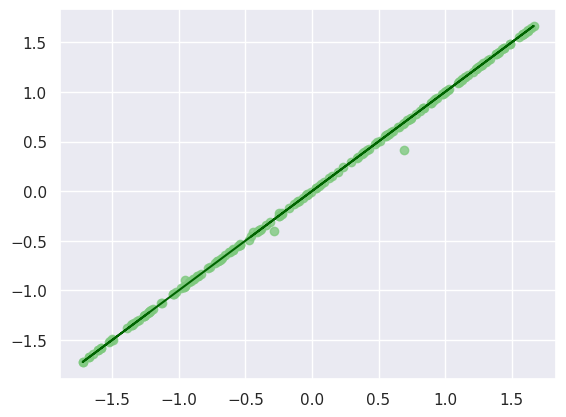

In [ ]:
plt.scatter(x=y_test, y=y_pred, alpha=0.8)
plt.plot(y_test, y_test, color='darkgreen')
plt.show()

In [ ]:
residuals = y_test - y_pred

The errors should not follow any pattern and equally distributed.

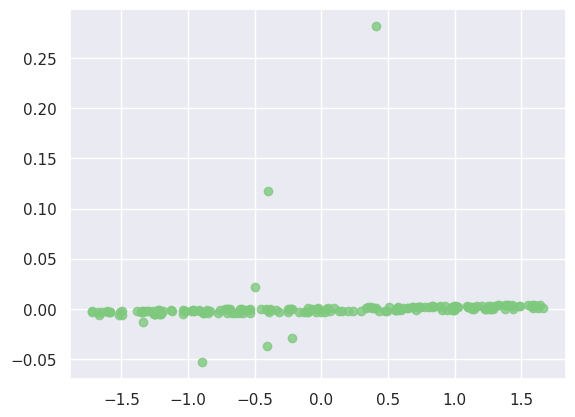

In [ ]:
plt.scatter(y=residuals, x=y_pred, alpha=0.8)
plt.show()

Calculating the coefficients and intercepts

In [ ]:
# Calculating the Coefficients (slope coefficients for each explanatary variable)
print("Coefficients (beta_1, beta_2, beta_3, beta_4, beta_5):",regression_model.coef_ )



Coefficients (beta_1, beta_2, beta_3, beta_4, beta_5): [ 0.93143245  0.0690423  -0.00167297 -0.00128983]


In [ ]:
# Calculating the Intercept (y-intercept / constant term)
print("Intercept (beta_0):", regression_model.intercept_)


Intercept (beta_0): 1.776807471948179e-16


Evaluating the model

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)



In [ ]:
r2


0.9995009371042611

In [ ]:
# Calculating the R squared value
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.9995009371042611

R squared value of 0.99 proves the model is a good model

## Our preferred model now has an equation that looks like this:

**PROFIT** = 1,777 + (0.931) `X` R&D Spend + (0.069) `X` Marketing Spend + (-0.002)` X` State_Florida + (-0.001) `X` State_New York

We successfully trained our model with certain predictors and estimated the profit of companies using linear regression